In [1]:
#import pandas to read and handle data
#get general info for our data

import pandas as pd

filename = 'yelp_labelled.txt'
yelp = pd.read_csv(filename, delimiter = '\t', header = None, names=['reviews', 'sentiment'])
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reviews    1000 non-null   object
 1   sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [2]:
#look at shape and first few rows of data

print(yelp.shape)
yelp.head()

(1000, 2)


,reviews,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


<Axes: xlabel='sentiment', ylabel='count'>

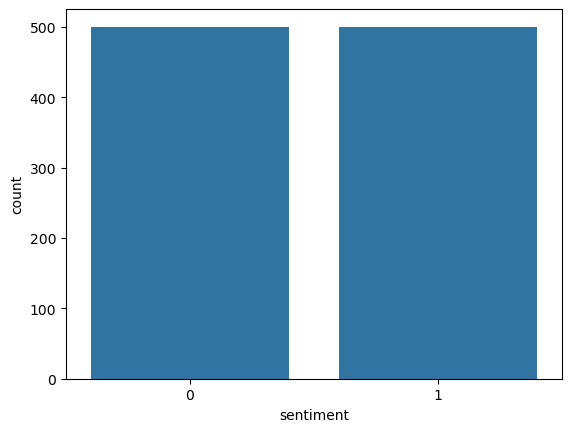

In [3]:
#import seaborn for visualization purposes
#create count plot of number of positive/negative sentiments

import seaborn as sb
sb.countplot(x = 'sentiment', data = yelp)

In [4]:
#check for missing values (none found)

yelp.isna().sum()

reviews      0
sentiment    0
dtype: int64

In [5]:
#initialize an empty list to store unique characters found in reviews column
#iterate through each review and character
#if unique,, adds it to the list
#print final list of characters

reviews = yelp['reviews']
list_of_characters = []
for comment in reviews: 
    for character in comment:
        if character not in list_of_characters:
            list_of_characters.append(character)
print(list_of_characters)

['W', 'o', 'w', '.', ' ', 'L', 'v', 'e', 'd', 't', 'h', 'i', 's', 'p', 'l', 'a', 'c', 'C', 'r', 'u', 'n', 'g', 'N', 'y', 'x', 'j', 'S', 'b', 'M', 'k', 'f', 'R', 'm', 'T', 'I', 'H', "'", 'A', ')', ',', '!', 'V', 'B', 'z', '-', '4', 'O', '2', '3', 'q', 'P', 'F', 'G', '5', '1', '0', 'E', 'Z', 'D', 'U', 'J', 'Y', 'K', '&', 'é', ':', ';', '9', '7', '(', 'X', '"', '/', '8', 'Q', '$', '%', '+', '*', '?', '6', 'ê']


In [6]:
#import re for text cleaning purposes and nltk for NLP tasks
#load set of common stopwords to remove
#initialize lemmatizer to reduce words to root form
#create empty list to store the cleaned reviews
#convert to lowercase and split into individual tokens

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

description_list = []

for description in yelp.reviews:
    description = re.sub("[^a-zA-Z]", " ", description)
    description = description.lower()
    tokens = nltk.word_tokenize(description)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    cleaned = " ".join(tokens)
    description_list.append(cleaned)

yelp['cleaned_reviews'] = description_list

In [7]:
#print the common stopwords that were removed

print(stop_words)

{'does', 'have', 'its', 'don', 'while', 'at', 'after', "she's", 'those', 'your', 'under', "she'd", "it'll", "weren't", "you'll", "aren't", "wouldn't", 'them', 'hers', "they've", "shan't", 'if', 'of', "haven't", 'than', 'being', "they're", 'during', 'below', 'were', 'will', 'out', 'am', 'doesn', 'myself', 'into', 'aren', 'himself', 'these', 'i', 'm', "we're", "that'll", 'wouldn', 'few', "hadn't", 'again', 'y', 'for', 'mightn', 'but', 'having', 'before', 'by', 'needn', 's', 'which', 'once', 'same', 'with', 'was', 'against', 'and', 'did', 'no', 'own', 'an', 't', 'yourself', 'yours', 'this', 'my', "couldn't", 'herself', "he's", 'itself', 'down', 'her', 'a', 'that', 'what', 'she', 'should', 'or', 'any', 'has', "we've", "won't", 'their', "it'd", 'had', 'about', 'more', 'such', 'do', 'him', 'until', 'when', 'shouldn', 'there', 'ours', 'o', 'so', 'the', 'some', 'weren', "you'd", 'too', "shouldn't", 'll', 'ma', "isn't", "she'll", 'above', 'just', 'most', 'is', "we'll", 'not', 'other', "he'd", '

In [8]:
#import tokenizer to vectorize text to integer sequences
#initialize tokenizer and fit on cleaned reviews to build word index
#calculate total number of unique words (+1 to account for padding index)
#print vocabulary size

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(yelp['cleaned_reviews'])
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocabulary_size)

Vocabulary size:  1769


In [9]:
#import numpy for numerical operations
#initialize empty list to store review lengths
#find min, max, and median review lengths and print these values

import numpy as np

review_length = []
for review in yelp['cleaned_reviews']:
    review_length.append(len(review.split(" ")))

review_max = np.max(review_length)
review_min = np.min(review_length)
review_median = np.median(review_length)
print("Max length of sequences: ", review_max)
print("Median length of sequences: ", review_median)
print("Min length of sequences: ", review_min)

Max length of sequences:  19
Median length of sequences:  5.0
Min length of sequences:  1


In [45]:
#convert ecah review to integer sequence and store
#calculate 95th percentile review length and print this value

review_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(description_list)]
print("Max review length:", max(review_lengths))
print("95th percentile:", np.percentile(review_lengths, 95))

Max review length: 19
95th percentile: 12.0


In [10]:
#import pad_sequences to pad sequences to fixed length
#convert reviews into integer sequences using word index mapping
#define max length based on calculated 95th percentile above
#pad sequences to length 12
#extract target variable and split data (80/20)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

X = tokenizer.texts_to_sequences(yelp['cleaned_reviews'])
max_length = 12
X = pad_sequences(X, maxlen=max_length)
y = yelp.sentiment.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

print("Training size: ", X_train.shape)
print("Testing size: ", X_test.shape)

Training size:  (800, 12)
Testing size:  (200, 12)


In [11]:
#print first padded review from training data to verify padding was applied correctly
#review has 5 padded 0s and 7 integers - length of 12 so we're good to go

print("First padded review:")
print(X_train[0])

First padded review:
[   0    0    0    0    0  107 1396  175   67   25 1397  124]


In [12]:
#convert training and testing sets to numpy arrays
#ensures compatibility with model requirements

train_pad = np.array(X_train)
train_label = np.array(y_train)

test_pad = np.array(X_test)
test_label = np.array(y_test)

In [13]:
#print shape of training and testing sets

print("Train features shape: ", train_pad.shape)
print("Train labels shape: ", train_label.shape)
print("Test features shape: ", test_pad.shape)
print("Test labels shape: ", test_label.shape)

Train features shape:  (800, 12)
Train labels shape:  (800,)
Test features shape:  (200, 12)
Test labels shape:  (200,)


In [14]:
#export each set to its own csv file for submission
#same with the cleaned dataframe

pd.DataFrame(train_pad).to_csv("d213_t2_ytr.csv")
pd.DataFrame(train_label).to_csv("d213_t2_ytrl.csv")
pd.DataFrame(test_pad).to_csv("d213_t2_yts.csv")
pd.DataFrame(test_label).to_csv("d213_t2_ytsl.csv")

pd.DataFrame(yelp).to_csv("d213_t2_yclean.csv")

In [15]:
#reshape training and testing sets to (n,1) for model compatibility (expects 2D input for y)

train_label = train_label.reshape(-1, 1)
test_label = test_label.reshape(-1, 1)

In [16]:
#import tensorflow modules for model building
#define hyperparameters
#build the model with each layer (embedding, LSTM, dense)
#compile model and track accuracy as performance metric
#train model using 70% training data and 30% for validation

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.models import Sequential

activation = 'sigmoid'
loss = 'binary_crossentropy'
optimizer = 'adam'
num_epochs = 30

early_stopping_mon = EarlyStopping(patience=4)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=64, input_length=(max_length,)),
    tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation=activation)
])

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_pad, train_label, batch_size=32, epochs=num_epochs, validation_split=0.3, callbacks=[early_stopping_mon], verbose=True)

Epoch 1/30


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5251 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5302 - loss: 0.6932 - val_accuracy: 0.5458 - val_loss: 0.6898
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6634 - loss: 0.6818 - val_accuracy: 0.6375 - val_loss: 0.6673
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7897 - loss: 0.5893 - val_accuracy: 0.7292 - val_loss: 0.5293
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8836 - loss: 0.2855 - val_accuracy: 0.7542 - val_loss: 0.5177
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9389 - loss: 0.1760 - val_accuracy: 0.7583 - val_loss: 0.5541
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9602 - loss: 0.0872 - val_accuracy: 0.7667 - val_loss: 0.6659
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9892 - loss: 0.0352 - val_accuracy: 0.7625 - val_loss: 0.8198

In [17]:
#print a summary of the model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 12, 64)         │       113,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 690,101 (2.63 MB)

 Trainable params: 230,033 (898.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 460,068 (1.76 MB)

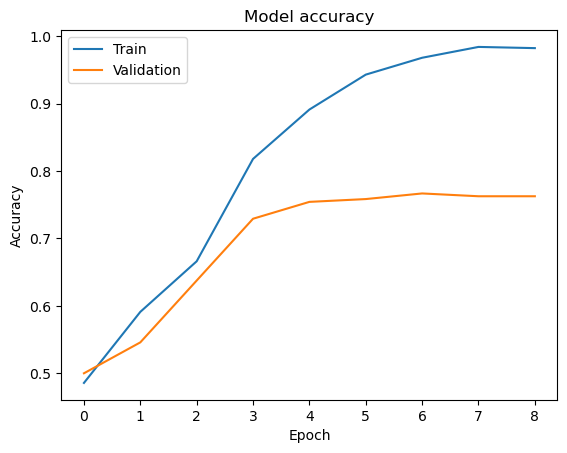

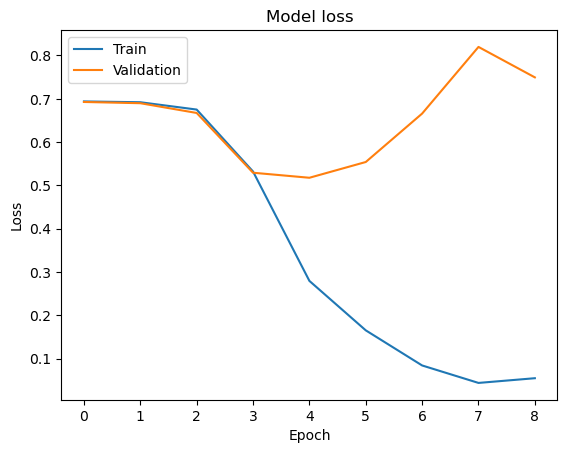

In [19]:
#import matplotlib for visualization purposes
#create two graphs - one for model accuracy and one for loss
#compare these between the training and validation sets

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


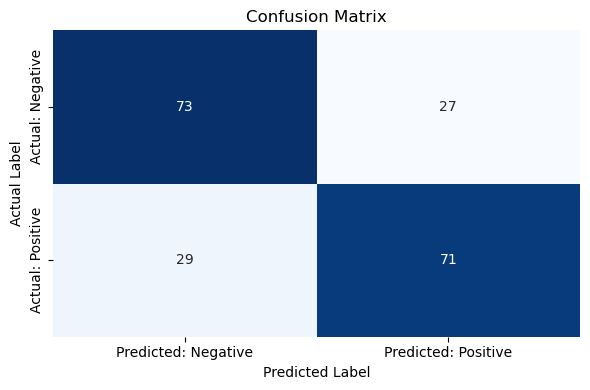

In [20]:
#import confusion_matrix for evaluation
#print confusion matrix with count labels, color scale, and labels for clarity

from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

conf_matrix = confusion_matrix(test_label, y_pred)

plt.figure(figsize=(6, 4))
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted: Negative", "Predicted: Positive"],
            yticklabels=["Actual: Negative", "Actual: Positive"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

In [21]:
#save model to hdf5 file for future reference

model.save('d213_sent_model.h5')